In [1]:
import pandas as pd

# Load train and test datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Drop the index column (Unnamed: 0)
train_data = train_data.drop(columns=['Unnamed: 0'])
test_data = test_data.drop(columns=['Unnamed: 0'])

# Display first few rows
print("Train Data:")
print(train_data.head())
print("\nTest Data:")
print(test_data.head())


Train Data:
           x          y  cls
0  -0.421121   0.989526    0
1  -2.313032   6.122276    0
2   1.831469   0.518892    1
3   1.135357   7.467182    0
4  16.431691  16.777048    1

Test Data:
           x         y  cls
0  11.539464  2.762008    1
1   0.912308 -0.129775    0
2   1.344378  0.214246    0
3   0.457303  0.514038    0
4   8.425323  9.075507    1


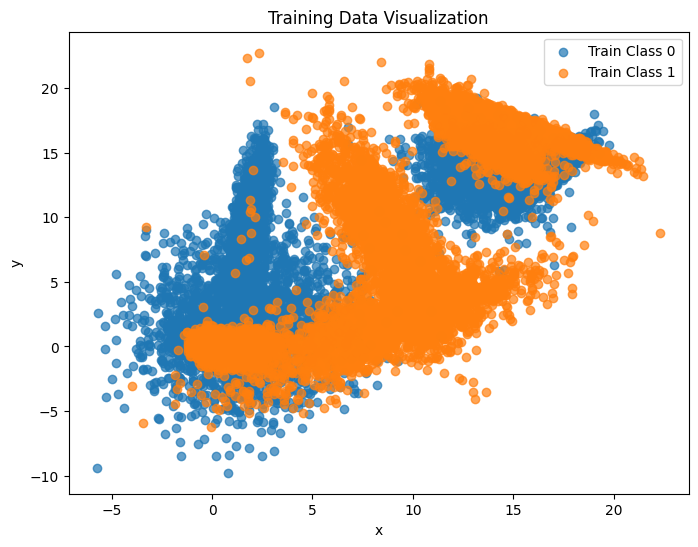

In [2]:
import matplotlib.pyplot as plt
# Visualize Training Data
plt.figure(figsize=(8, 6))
for label in train_data['cls'].unique():
    subset = train_data[train_data['cls'] == label]
    plt.scatter(subset['x'], subset['y'], label=f'Train Class {label}', alpha=0.7)

plt.title("Training Data Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Phase 1: Bagging

In [3]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid
from collections import Counter

def generate_bootstrap_datasets(data, n_datasets):
    """Generate multiple bootstrap datasets."""
    return [data.sample(len(data), replace=True) for _ in range(n_datasets)]

def train_models(bootstrap_datasets, target_column, max_depth, min_samples_leaf):
    """Train a decision tree on each bootstrap dataset."""
    models = []
    for dataset in bootstrap_datasets:
        X, y = dataset.drop(columns=target_column), dataset[target_column]
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42).fit(X, y)
        models.append(model)
    return models

def aggregate_predictions(models, X, method="voting"):
    """Aggregate predictions from all models."""
    predictions = np.array([model.predict(X) for model in models])
    if method == "voting":
        return [Counter(row).most_common(1)[0][0] for row in predictions.T]
    if method == "averaging":
        return predictions.mean(axis=0)
    raise ValueError("Unsupported aggregation method")

def evaluate_model(train_data, test_data, params):
    """Evaluate the bagging ensemble with given hyperparameters."""
    # Generate bootstrap datasets
    bootstrap_datasets = generate_bootstrap_datasets(train_data, params['n_estimators'])

    # Train models with specified hyperparameters
    models = train_models(
        bootstrap_datasets, target_column='cls',
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf']
    )

    # Prepare train and test features
    X_train, y_train = train_data.drop(columns=['cls']), train_data['cls']
    X_test, y_test = test_data.drop(columns=['cls']), test_data['cls']

    # Aggregate predictions for train and test
    train_predictions = aggregate_predictions(models, X_train, method="voting")
    test_predictions = aggregate_predictions(models, X_test, method="voting")

    # Calculate accuracy
    accuracy_train = accuracy_score(y_train, train_predictions)
    accuracy_test = accuracy_score(y_test, test_predictions)

    # Calculate metrics
    precision_train = precision_score(y_train, train_predictions)
    recall_train = recall_score(y_train, train_predictions)
    f1_train = f1_score(y_train, train_predictions)

    precision_test = precision_score(y_test, test_predictions)
    recall_test = recall_score(y_test, test_predictions)
    f1_test = f1_score(y_test, test_predictions)

    return accuracy_train, accuracy_test, precision_train, recall_train, f1_train, precision_test, recall_test, f1_test, test_predictions, models

def plot_accuracy_vs_n_estimators(train_data, test_data, n_estimators_range):
    train_accuracies = []
    test_accuracies = []

    for n in n_estimators_range:
        accuracy_train, accuracy_test = evaluate_model(train_data, test_data, n)
        train_accuracies.append(accuracy_train)
        test_accuracies.append(accuracy_test)

    plt.plot(n_estimators_range, train_accuracies, label='Train Accuracy')
    plt.plot(n_estimators_range, test_accuracies, label='Test Accuracy')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Estimators')
    plt.legend()
    plt.show()

In [52]:
# Load train and test datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Drop the index column (Unnamed: 0)
train_data = train_data.drop(columns=['Unnamed: 0'])
test_data = test_data.drop(columns=['Unnamed: 0'])

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

# Define hyperparameter grid
param_grid = {
    'n_estimators': [5, 10, 20],
    'max_depth': [5, 10, 12],
    'min_samples_leaf': [1, 5, 10]
}

# Perform grid search
best_params = None
best_accuracy_test = 0
grid = ParameterGrid(param_grid)

for params in grid:
    accuracy_train, accuracy_test, precision_train, recall_train, f1_train, precision_test, recall_test, f1_test, test_predictions, models = evaluate_model(train_data, test_data, params)
    #print(f"Params: {params}, Train Accuracy: {accuracy_train:.4f}, Test Accuracy: {accuracy_test:.4f}")
    print(f"Train - Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1 Score: {f1_train:.4f}")
    print(f"Test  - Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}")

    if accuracy_test > best_accuracy_test:
        best_accuracy_test = accuracy_test
        best_accuracy_train = accuracy_train
        best_params = params

# Final print with added F1, precision, recall for best train and test accuracy
print(f"Best Params: {best_params}, Best Test Accuracy: {best_accuracy_test:.4f}, Best Train Accuracy: {best_accuracy_train:.4f}")
print(f"Best Train Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1 Score: {f1_train:.4f}")
print(f"Best Test Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}")

x_train shape: (24000, 2), y_train shape: (24000,)
Train - Precision: 0.8556, Recall: 0.8667, F1 Score: 0.8611
Test  - Precision: 0.8509, Recall: 0.8643, F1 Score: 0.8576
Train - Precision: 0.8578, Recall: 0.8663, F1 Score: 0.8621
Test  - Precision: 0.8526, Recall: 0.8643, F1 Score: 0.8584
Train - Precision: 0.8556, Recall: 0.8650, F1 Score: 0.8603
Test  - Precision: 0.8484, Recall: 0.8623, F1 Score: 0.8553
Train - Precision: 0.8622, Recall: 0.8495, F1 Score: 0.8558
Test  - Precision: 0.8532, Recall: 0.8469, F1 Score: 0.8500
Train - Precision: 0.8643, Recall: 0.8465, F1 Score: 0.8553
Test  - Precision: 0.8566, Recall: 0.8506, F1 Score: 0.8536
Train - Precision: 0.8600, Recall: 0.8569, F1 Score: 0.8585
Test  - Precision: 0.8555, Recall: 0.8570, F1 Score: 0.8562
Train - Precision: 0.8612, Recall: 0.8517, F1 Score: 0.8564
Test  - Precision: 0.8514, Recall: 0.8523, F1 Score: 0.8518
Train - Precision: 0.8579, Recall: 0.8572, F1 Score: 0.8575
Test  - Precision: 0.8512, Recall: 0.8570, F1 Sco

Implementation of Bagging with sklearn

In [56]:
import pandas as pd
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Drop the index column (Unnamed: 0)
train_data = train_data.drop(columns=['Unnamed: 0'])
test_data = test_data.drop(columns=['Unnamed: 0'])

# Prepare train and test features
x_train, y_train = train_data.drop(columns=['cls']), train_data['cls']
x_test, y_test = test_data.drop(columns=['cls']), test_data['cls']

# Bagging Classifier with DecisionTree
bg_clf2 = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=12, min_samples_leaf=1, random_state=42), n_estimators=20, random_state=42)
bg_clf2.fit(x_train, y_train)

# Accuracy, Precision, Recall, and F1 score on train set
accuracy_train = accuracy_score(y_train, bg_clf2.predict(x_train))
precision_train = precision_score(y_train, bg_clf2.predict(x_train))
recall_train = recall_score(y_train, bg_clf2.predict(x_train))
f1_train = f1_score(y_train, bg_clf2.predict(x_train))

# Accuracy, Precision, Recall, and F1 score on test set
accuracy_test = accuracy_score(y_test, bg_clf2.predict(x_test))
precision_test = precision_score(y_test, bg_clf2.predict(x_test))
recall_test = recall_score(y_test, bg_clf2.predict(x_test))
f1_test = f1_score(y_test, bg_clf2.predict(x_test))

# Print metrics
print(f"Train Accuracy: {accuracy_train}")
print(f"Test Accuracy: {accuracy_test}")
print(f"Train Precision: {precision_train}")
print(f"Test Precision: {precision_test}")
print(f"Train Recall: {recall_train}")
print(f"Test Recall: {recall_test}")
print(f"Train F1 Score: {f1_train}")
print(f"Test F1 Score: {f1_test}")


Train Accuracy: 0.916125
Test Accuracy: 0.8683333333333333
Train Precision: 0.9046193673651
Test Precision: 0.8548334949886841
Train Recall: 0.9305925432756325
Test Recall: 0.8857621440536013
Train F1 Score: 0.9174221602330065
Test F1 Score: 0.8700230338927278


In [6]:
from sklearn.preprocessing import LabelEncoder
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  

def plot_decision_boundaries(X, y, predictions, models, title, num_trees_to_plot=5):
    """Visualize decision boundaries with data points."""
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Ensure X is a NumPy array
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    # Create subplots for individual trees and the ensemble
    num_rows = (num_trees_to_plot + 1) // 2
    num_cols = 2 if (num_trees_to_plot + 1) > 2 else 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.ravel()

    # Plot individual trees
    for i in range(num_trees_to_plot):
        ax = axes[i]
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_encoded, palette='deep', alpha=0.6, ax=ax)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
        Z = models[i].predict(np.c_[xx.ravel(), yy.ravel()])  # Use NumPy array
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.5, cmap='coolwarm')

        ax.set_title(f'Tree {i + 1} Decision Boundaries')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')

    # Plot Bagging ensemble
    ax = axes[-1]
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_encoded, palette='deep', alpha=0.6, ax=ax)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    # Get predictions from all trees and average them
    ensemble_predictions = np.mean([model.predict(np.c_[xx.ravel(), yy.ravel()]) for model in models], axis=0)
    Z = ensemble_predictions.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.5, cmap='coolwarm')

    ax.set_title('Bagging Ensemble Decision Boundaries')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

    plt.tight_layout()
    plt.show()


c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature n

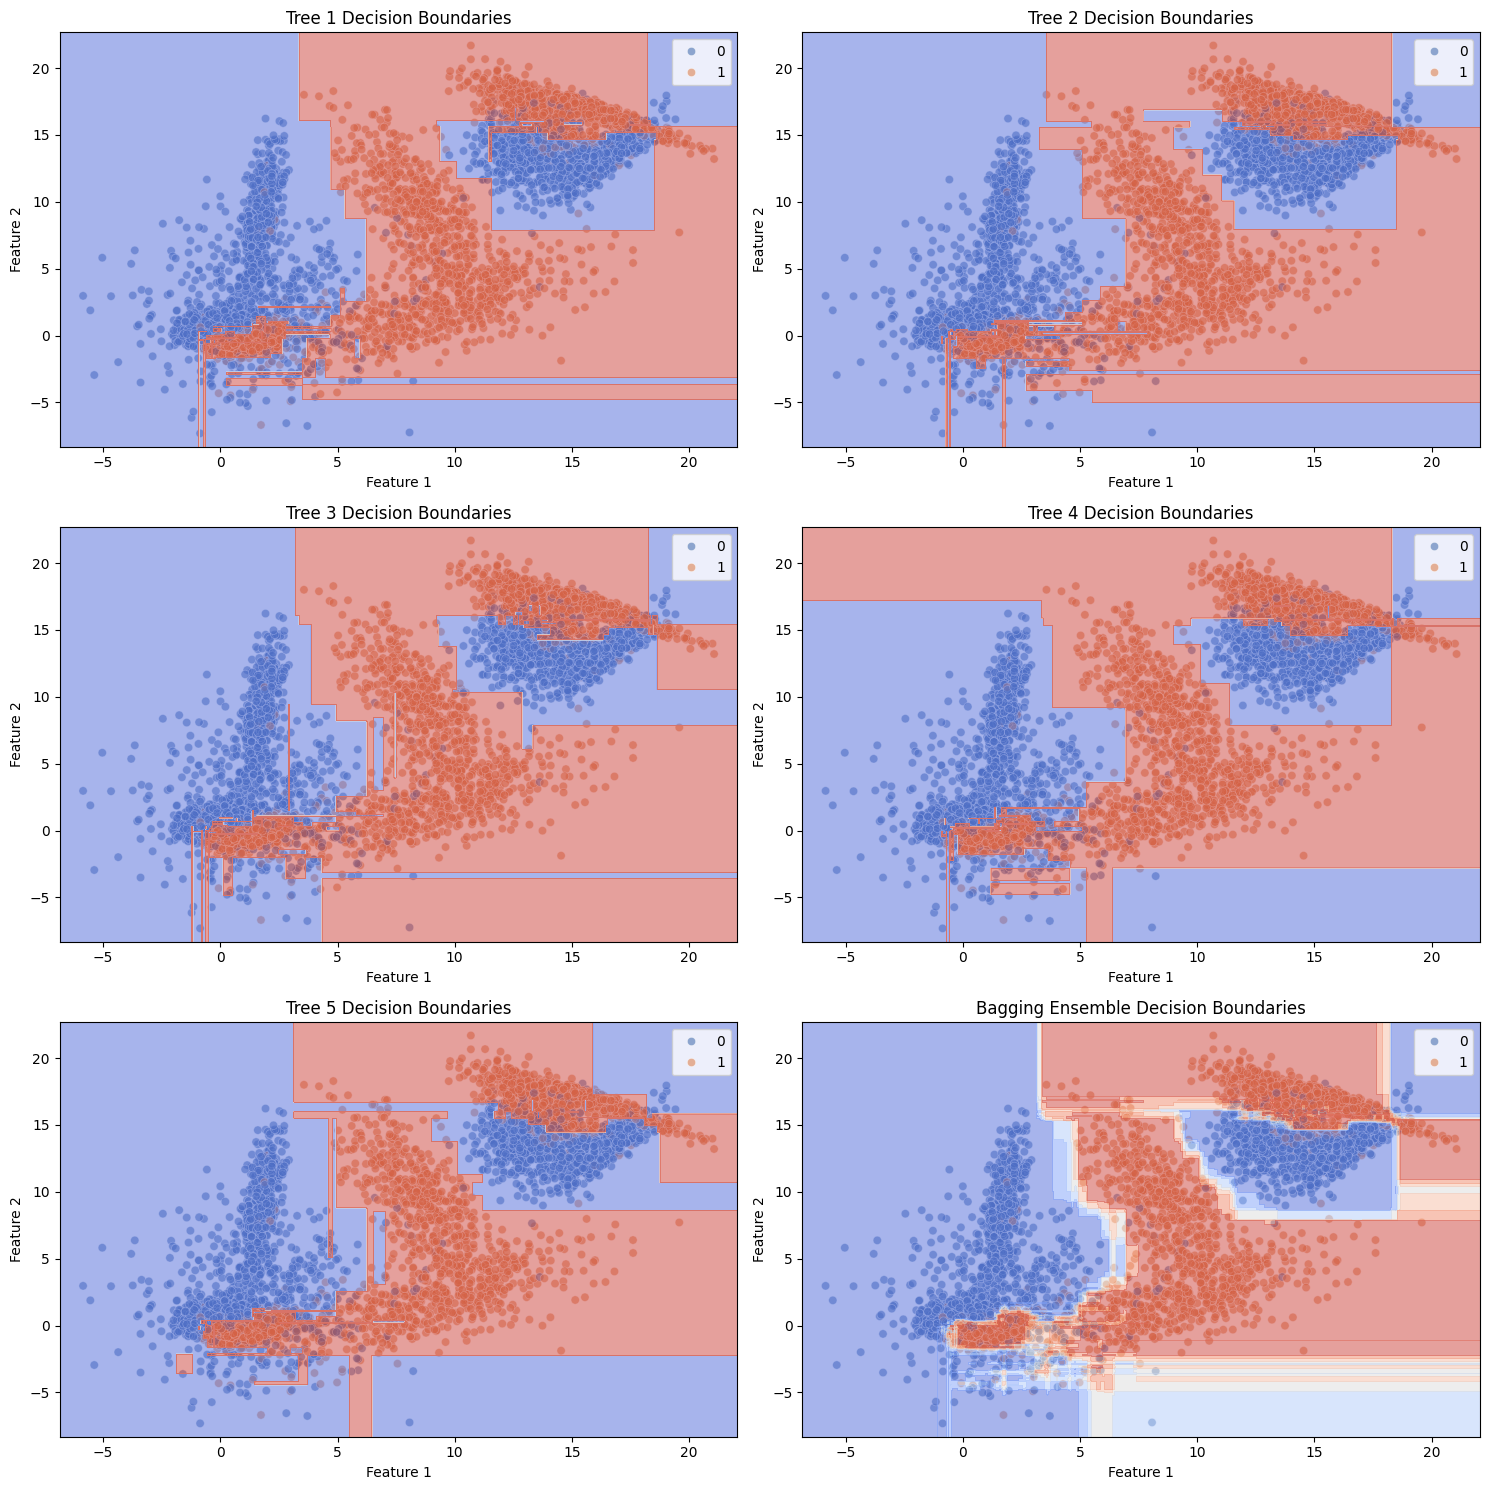

In [7]:
# Assuming you have the 'best_params' from grid search
accuracy_train, accuracy_test, precision_train, recall_train, f1_train, precision_test, recall_test, f1_test, test_predictions, models = evaluate_model(train_data, test_data, best_params)
plot_decision_boundaries(x_test, y_test, test_predictions, models, 'Bagging Model Decision Boundaries')

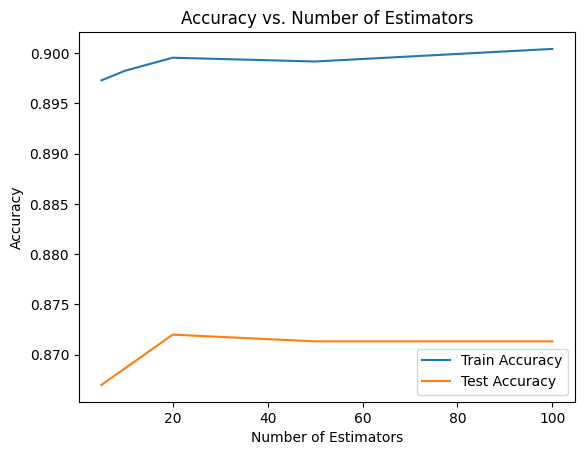

In [8]:
def plot_accuracy_vs_n_estimators(train_data, test_data, n_estimators_range):
    train_accuracies = []
    test_accuracies = []

    for n in n_estimators_range:
        # Create a dictionary to hold the n_estimators value
        params = {'n_estimators': n, 'max_depth': 12, 'min_samples_leaf': 5}
        accuracy_train, accuracy_test, _, _, _, _, _, _, _, _ = evaluate_model(train_data, test_data, params)
        train_accuracies.append(accuracy_train)
        test_accuracies.append(accuracy_test)

    plt.plot(n_estimators_range, train_accuracies, label='Train Accuracy')
    plt.plot(n_estimators_range, test_accuracies, label='Test Accuracy')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Estimators')
    plt.legend()
    plt.show()
# Define a range for n_estimators
n_estimators_range = [5, 10, 20, 50, 100]

# Plot accuracy
plot_accuracy_vs_n_estimators(train_data, test_data, n_estimators_range)

Phase 2: RandomForest

In [54]:
import numpy as np
import pandas as pd
from collections import Counter
from random import sample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid

def generate_bootstrap_datasets(data, n_datasets):
    """Generate multiple bootstrap datasets."""
    return [data.sample(len(data), replace=True) for _ in range(n_datasets)]

def train_random_forest_models(bootstrap_datasets, target_column, max_depth, min_samples_leaf, max_features):
    """Train decision trees on bootstrap datasets with feature subsampling."""
    models = []
    feature_subsets = []

    for dataset in bootstrap_datasets:
        X, y = dataset.drop(columns=target_column), dataset[target_column]
        features = sample(list(X.columns), max_features)  # Randomly select a subset of features
        X_subset = X[features]  # Use only the selected features

        # Train the decision tree with the subset of features
        tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        tree.fit(X_subset, y)
        models.append(tree)
        feature_subsets.append(features)

    return models, feature_subsets

def aggregate_predictions_random_forest(models, feature_subsets, X, method="voting"):
    """Aggregate predictions from random forest models."""
    predictions = []

    for model, features in zip(models, feature_subsets):
        X_subset = X[features]  # Use only the features selected for this model
        predictions.append(model.predict(X_subset))

    predictions = np.array(predictions)

    if method == "voting":
        return [Counter(row).most_common(1)[0][0] for row in predictions.T]
    if method == "averaging":
        return predictions.mean(axis=0)
    raise ValueError("Unsupported aggregation method")

def evaluate_random_forest(train_data, test_data, params):
    """Evaluate the random forest ensemble with given hyperparameters."""
    # Generate bootstrap datasets
    bootstrap_datasets = generate_bootstrap_datasets(train_data, params['n_estimators'])

    # Train random forest models
    models, feature_subsets = train_random_forest_models(
        bootstrap_datasets,
        target_column='cls',
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=params['max_features']
    )

    # Prepare train and test features
    X_train, y_train = train_data.drop(columns=['cls']), train_data['cls']
    X_test, y_test = test_data.drop(columns=['cls']), test_data['cls']

    # Aggregate predictions for train and test
    train_predictions = aggregate_predictions_random_forest(models, feature_subsets, X_train, method="voting")
    test_predictions = aggregate_predictions_random_forest(models, feature_subsets, X_test, method="voting")

    # Calculate accuracy
    accuracy_train = accuracy_score(y_train, train_predictions)
    accuracy_test = accuracy_score(y_test, test_predictions)

    # Calculate additional metrics
    precision_train = precision_score(y_train, train_predictions, average='weighted')
    recall_train = recall_score(y_train, train_predictions, average='weighted')
    f1_train = f1_score(y_train, train_predictions, average='weighted')

    precision_test = precision_score(y_test, test_predictions, average='weighted')
    recall_test = recall_score(y_test, test_predictions, average='weighted')
    f1_test = f1_score(y_test, test_predictions, average='weighted')

    return accuracy_train, accuracy_test, precision_train, recall_train, f1_train, precision_test, recall_test, f1_test



# Load train and test datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Drop the index column (Unnamed: 0)
train_data = train_data.drop(columns=['Unnamed: 0'])
test_data = test_data.drop(columns=['Unnamed: 0'])

# Define hyperparameter grid
param_grid = {
    'n_estimators': [5, 10, 20],
    'max_depth': [5, 10, 12],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [1, 2]  # Adjust based on the total number of features
}

# Perform grid search
best_params = None
best_accuracy_test = 0
best_accuracy_train = 0
grid = ParameterGrid(param_grid)

for params in grid:
    accuracy_train, accuracy_test, precision_train, recall_train, f1_train, precision_test, recall_test, f1_test = evaluate_random_forest(train_data, test_data, params)
    
    # Print evaluation metrics for each combination of hyperparameters
    print(f"Params: {params}")
    print(f"Train - Accuracy: {accuracy_train:.4f}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1 Score: {f1_train:.4f}")
    print(f"Test  - Accuracy: {accuracy_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}")
    
    # Track best parameters based on test accuracy
    if accuracy_test > best_accuracy_test:
        best_accuracy_test = accuracy_test
        best_accuracy_train = accuracy_train
        best_params = params

print(f"Best Params: {best_params}, Best Test Accuracy: {best_accuracy_test:.4f}, Best Train Accuracy: {best_accuracy_train:.4f}")
print(f"Best Train Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1 Score: {f1_train:.4f}")
print(f"Best Test Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}")

Params: {'max_depth': 5, 'max_features': 1, 'min_samples_leaf': 1, 'n_estimators': 5}
Train - Accuracy: 0.7197, Precision: 0.7213, Recall: 0.7197, F1 Score: 0.7192
Test  - Accuracy: 0.7117, Precision: 0.7130, Recall: 0.7117, F1 Score: 0.7111
Params: {'max_depth': 5, 'max_features': 1, 'min_samples_leaf': 1, 'n_estimators': 10}
Train - Accuracy: 0.7194, Precision: 0.7204, Recall: 0.7194, F1 Score: 0.7191
Test  - Accuracy: 0.7108, Precision: 0.7116, Recall: 0.7108, F1 Score: 0.7105
Params: {'max_depth': 5, 'max_features': 1, 'min_samples_leaf': 1, 'n_estimators': 20}
Train - Accuracy: 0.7301, Precision: 0.7314, Recall: 0.7301, F1 Score: 0.7298
Test  - Accuracy: 0.7208, Precision: 0.7218, Recall: 0.7208, F1 Score: 0.7205
Params: {'max_depth': 5, 'max_features': 1, 'min_samples_leaf': 5, 'n_estimators': 5}
Train - Accuracy: 0.7173, Precision: 0.7180, Recall: 0.7173, F1 Score: 0.7170
Test  - Accuracy: 0.7075, Precision: 0.7081, Recall: 0.7075, F1 Score: 0.7072
Params: {'max_depth': 5, 'max_

c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature n

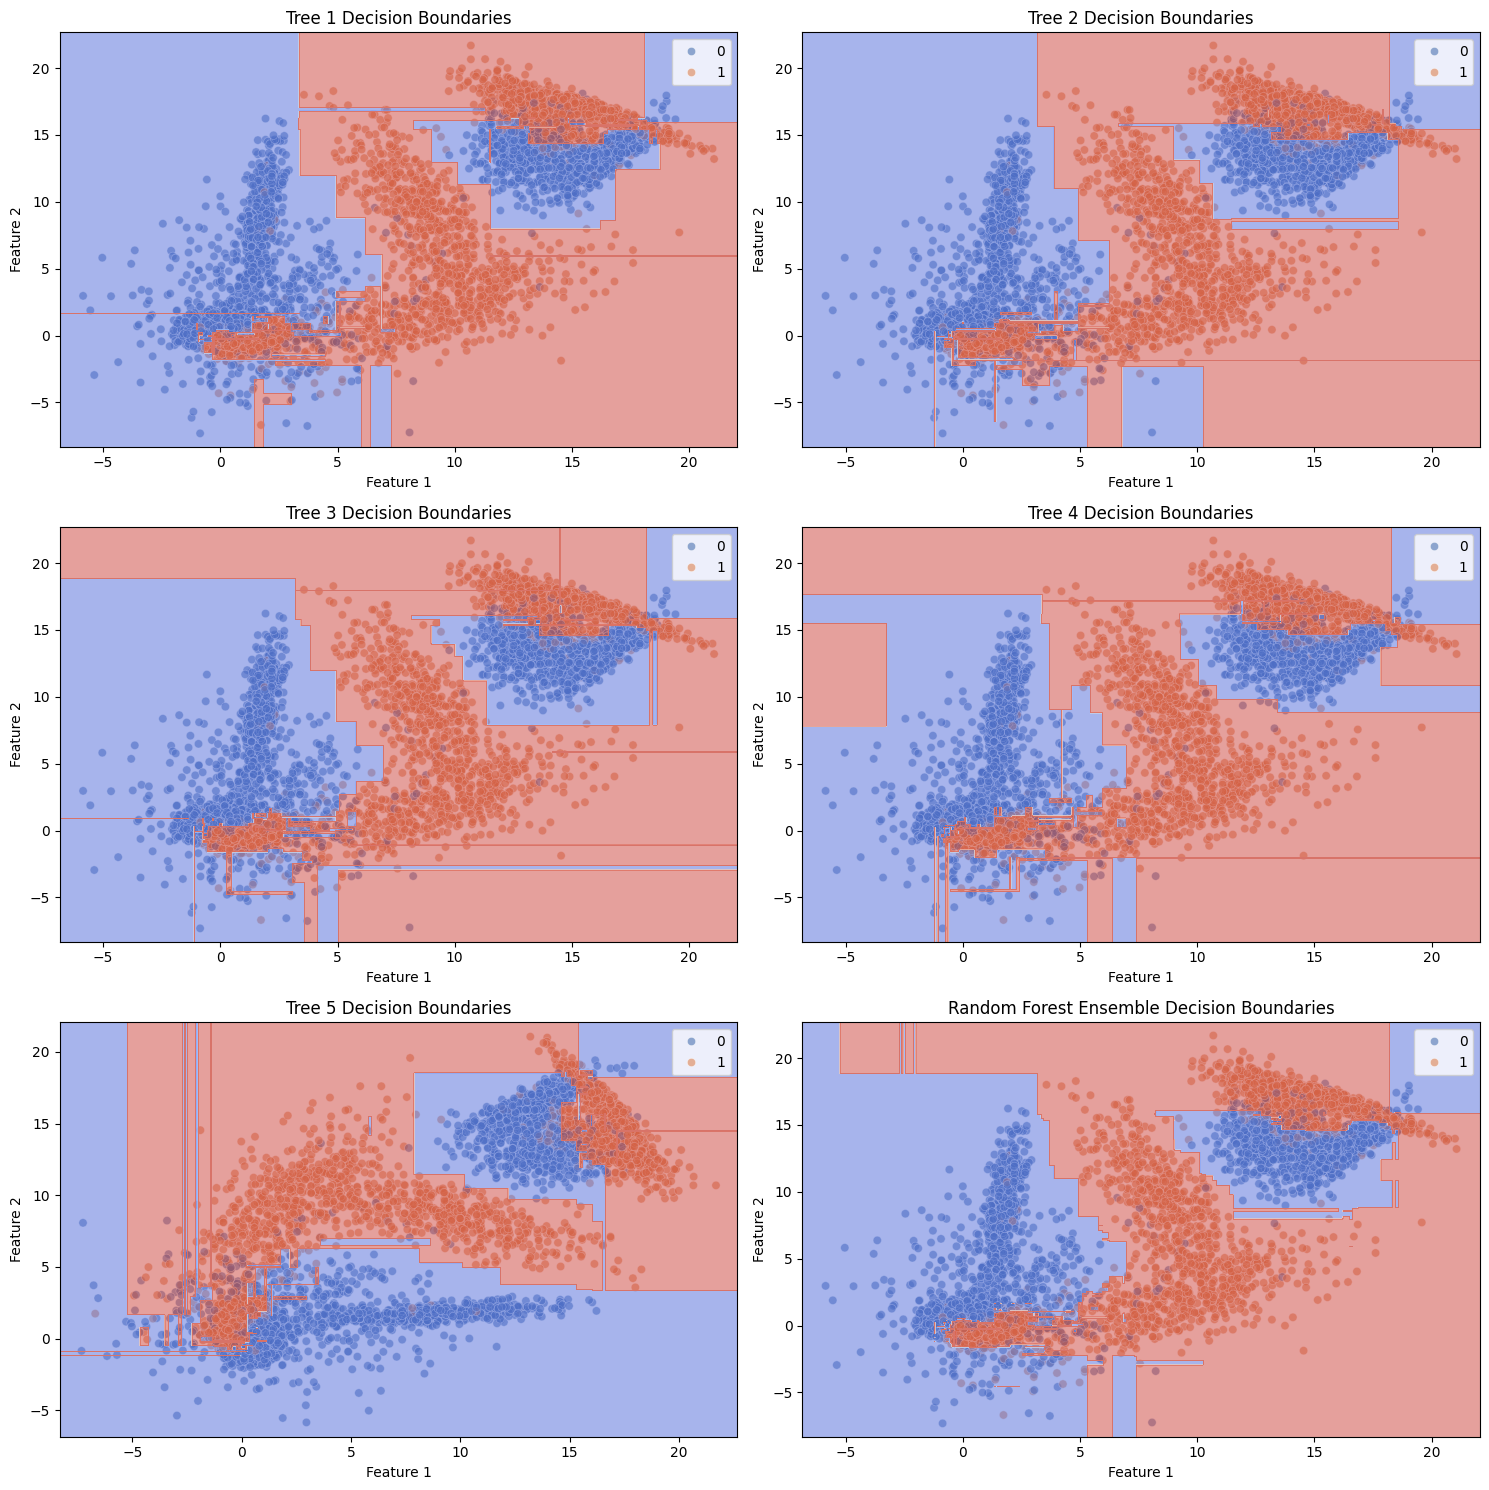

In [33]:
def plot_random_forest_boundaries(X, y, models, feature_subsets, num_trees_to_plot=5):
    """Visualize decision boundaries for random forest models."""
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Ensure X is a NumPy array
    X_array = X.to_numpy() if isinstance(X, pd.DataFrame) else X

    # Select models and subsets of features
    selected_models = models[:num_trees_to_plot]
    selected_features = feature_subsets[:num_trees_to_plot]

    num_rows = (num_trees_to_plot + 1) // 2
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.ravel()

    for i, (model, features) in enumerate(zip(selected_models, selected_features)):
        ax = axes[i]
        if isinstance(X, pd.DataFrame):
            X_subset = X[features].to_numpy()
        else:
            feature_indices = [X.columns.get_loc(f) for f in features]
            X_subset = X_array[:, feature_indices]

        # Scatterplot for the two selected features
        sns.scatterplot(x=X_subset[:, 0], y=X_subset[:, 1], hue=y_encoded, palette='deep', alpha=0.6, ax=ax)

        x_min, x_max = X_subset[:, 0].min() - 1, X_subset[:, 0].max() + 1
        y_min, y_max = X_subset[:, 1].min() - 1, X_subset[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.5, cmap='coolwarm')

        ax.set_title(f'Tree {i + 1} Decision Boundaries')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')

    # Ensemble decision boundaries
    ax = axes[-1]
    sns.scatterplot(x=X_array[:, 0], y=X_array[:, 1], hue=y_encoded, palette='deep', alpha=0.6, ax=ax)

    xx, yy = np.meshgrid(np.arange(X_array[:, 0].min() - 1, X_array[:, 0].max() + 1, 0.02),
                         np.arange(X_array[:, 1].min() - 1, X_array[:, 1].max() + 1, 0.02))

    ensemble_predictions = np.mean(
        [model.predict(np.c_[xx.ravel(), yy.ravel()]) for model, features in zip(selected_models, selected_features)],
        axis=0
    )
    Z = (ensemble_predictions > 0.5).astype(int).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.5, cmap='coolwarm')

    ax.set_title('Random Forest Ensemble Decision Boundaries')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

    plt.tight_layout()
    plt.show()

X_test, y_test = test_data.drop(columns=['cls']), test_data['cls']
plot_random_forest_boundaries(X_test, y_test, models, feature_subsets)


In [ ]:
Precision Graph on RandomForest

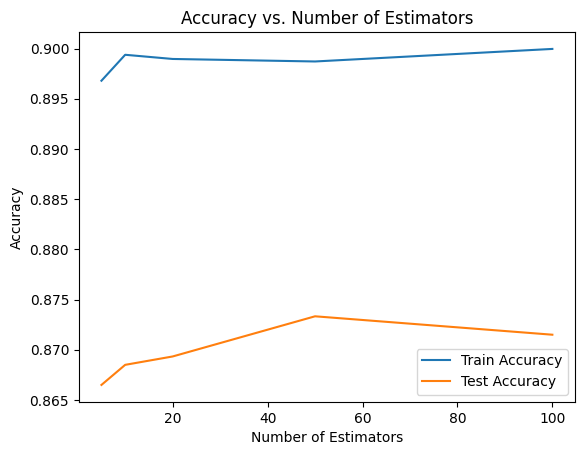

In [11]:
# Define a range for n_estimators
n_estimators_range = [5, 10, 20, 50, 100]

# Plot accuracy
plot_accuracy_vs_n_estimators(train_data, test_data, n_estimators_range)

Implementation of Random Forest with sklearn:

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import pandas as pd
import numpy as np

# Split data into features and labels
X = test_data.drop(columns=['cls'])  # Feature set
y = test_data['cls']                 # Target labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Parameters
n_estimators = 20  # Number of decision trees
max_features = 2    # Number of features considered at each split

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth = 10, max_features=max_features, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Evaluate the model on the training set
y_train_pred = rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Evaluate the model on the test set
y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print training metrics
print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

# Print test metrics
print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


Training Set Metrics:
Accuracy: 0.9240
Precision: 0.9241
Recall: 0.9240
F1 Score: 0.9240

Test Set Metrics:
Accuracy: 0.8733
Precision: 0.8737
Recall: 0.8733
F1 Score: 0.8734


phase 3

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics

# Create AdaBoost classifier object
abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)

# Train Adaboost Classifier
train_model = abc.fit(x_train, y_train)

# Predict the response for the train and test datasets
y_train_pred = train_model.predict(x_train)
y_test_pred = train_model.predict(x_test)

# Compute evaluation metrics for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Compute evaluation metrics for test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print metrics
print(f"Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

print(f"\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training Metrics:
Accuracy: 0.8512
Precision: 0.8518
Recall: 0.8512
F1 Score: 0.8512

Testing Metrics:
Accuracy: 0.8470
Precision: 0.8474
Recall: 0.8470
F1 Score: 0.8469


c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecat

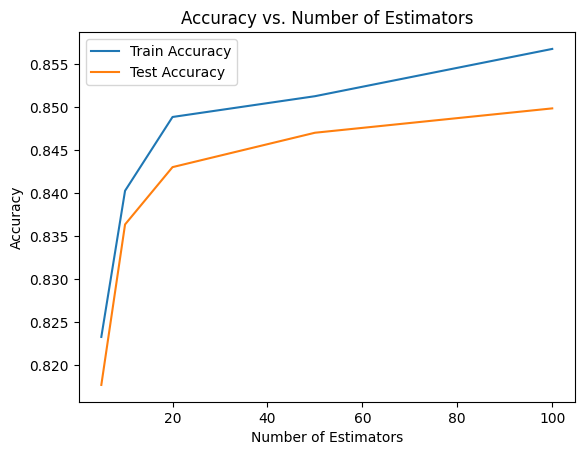

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy_vs_n_estimators(x_train, y_train, x_test, y_test, n_estimators_range):
    train_accuracies = []
    test_accuracies = []

    for n in n_estimators_range:
        abc = AdaBoostClassifier(n_estimators=n, learning_rate=1)
        abc.fit(x_train, y_train)  # Train Adaboost Classifier

        # Compute accuracies
        train_accuracy = accuracy_score(y_train, abc.predict(x_train))
        test_accuracy = accuracy_score(y_test, abc.predict(x_test))

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    # Plot accuracies
    plt.plot(n_estimators_range, train_accuracies, label='Train Accuracy')
    plt.plot(n_estimators_range, test_accuracies, label='Test Accuracy')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Estimators')
    plt.legend()
    plt.show()

# Define a range for n_estimators
n_estimators_range = [5, 10, 20, 50, 100]

# Example call (replace x_train, y_train, x_test, y_test with your data)
plot_accuracy_vs_n_estimators(x_train, y_train, x_test, y_test, n_estimators_range)


c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has featu

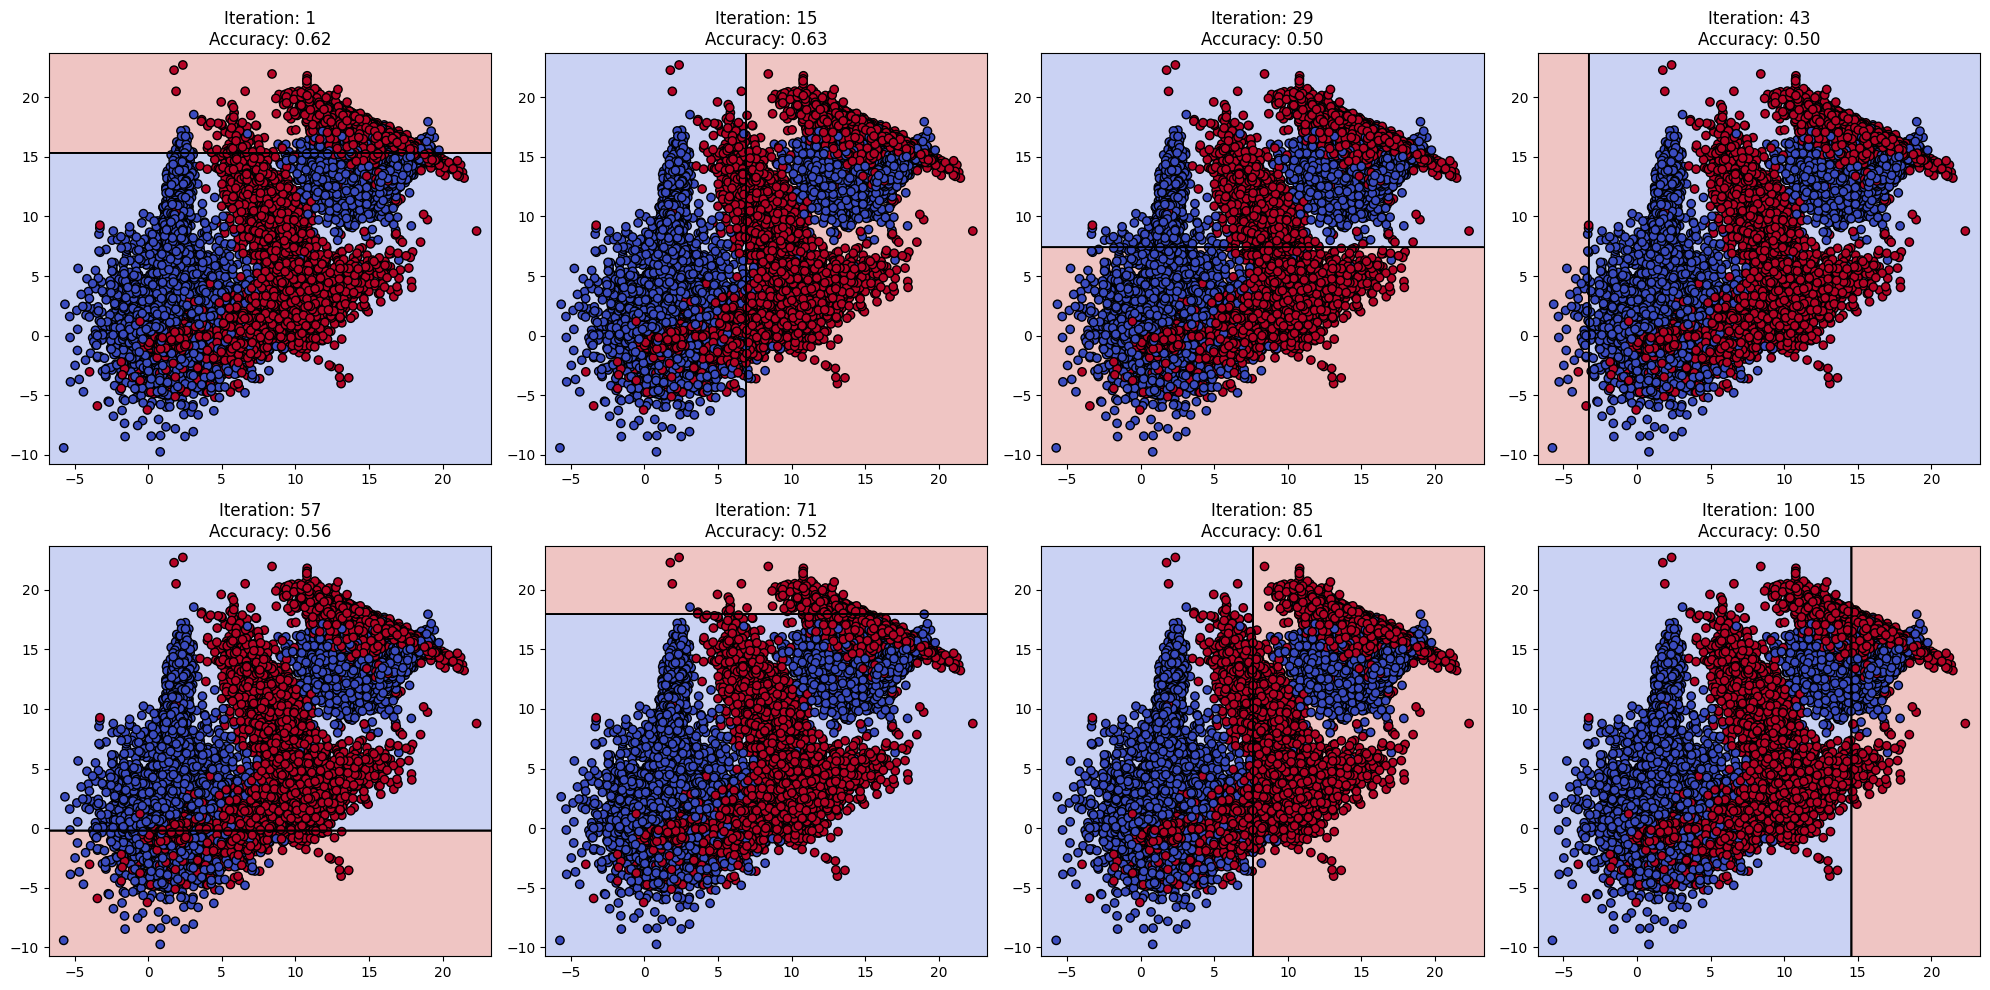

In [22]:
def plot_decision_boundary(classifier, x, y, ax, iteration, accuracy):
    # Convert data to numpy arrays
    x = np.array(x)
    y = np.array(y)

    # Define grid limits
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Predict over the grid
    z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)

    # Plot decision boundary
    ax.contourf(xx, yy, z, alpha=0.3, cmap=plt.cm.coolwarm)
    ax.contour(xx, yy, z, colors='k', linewidths=1, alpha=0.7)

    # Scatter plot of data
    scatter = ax.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    ax.set_title(f"Iteration: {iteration}\nAccuracy: {accuracy:.2f}")

def plot_performance_over_stages(model, x_train, y_train, n_estimators):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    iterations_to_plot = np.linspace(1, n_estimators, 8, dtype=int)

    for idx, iteration in enumerate(iterations_to_plot):
        weak_classifier = model.estimators_[iteration - 1]  # Access weak classifier
        y_pred_weak = weak_classifier.predict(x_train)  # Predictions of weak classifier
        accuracy = accuracy_score(y_train, y_pred_weak)  # Accuracy on training data

        ax = axes[idx // 4, idx % 4]
        plot_decision_boundary(weak_classifier, x_train, y_train, ax, iteration, accuracy)

    plt.tight_layout()
    plt.show()

# Train AdaBoost classifier
abc = AdaBoostClassifier(n_estimators=100, learning_rate=1)
abc.fit(x_train, y_train)

# Example call
plot_performance_over_stages(abc, x_train, y_train, n_estimators=100)

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC  
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

# Load datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Drop the index column (Unnamed: 0)
train_data = train_data.drop(columns=['Unnamed: 0'])
test_data = test_data.drop(columns=['Unnamed: 0'])

# Prepare train and test features
x_train, y_train = train_data.drop(columns=['cls']), train_data['cls']
x_test, y_test = test_data.drop(columns=['cls']), test_data['cls']

# Define base classifiers
clf1 = LogisticRegression(random_state=42)
clf2 = CatBoostClassifier(verbose=50)  
clf3 = LinearDiscriminantAnalysis()
clf4 = GaussianNB()

# Hyperparameter grids for each classifier
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

param_grid_catboost = {  
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8]
}

param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen']
}

param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

# Perform hyperparameter tuning
grid_search_lr = GridSearchCV(clf1, param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(x_train, y_train)
clf1 = grid_search_lr.best_estimator_

grid_search_catboost = GridSearchCV(clf2, param_grid_catboost, cv=5, scoring='accuracy')
grid_search_catboost.fit(x_train, y_train)
clf2 = grid_search_catboost.best_estimator_

grid_search_lda = GridSearchCV(clf3, param_grid_lda, cv=5, scoring='accuracy')
grid_search_lda.fit(x_train, y_train)
clf3 = grid_search_lda.best_estimator_

grid_search_nb = GridSearchCV(clf4, param_grid_nb, cv=5, scoring='accuracy')
grid_search_nb.fit(x_train, y_train)
clf4 = grid_search_nb.best_estimator_

0:	learn: 0.6891056	total: 171ms	remaining: 16.9s
50:	learn: 0.5583186	total: 513ms	remaining: 493ms
99:	learn: 0.4940353	total: 873ms	remaining: 0us
0:	learn: 0.6890841	total: 5.03ms	remaining: 498ms
50:	learn: 0.5577282	total: 328ms	remaining: 316ms
99:	learn: 0.4952800	total: 666ms	remaining: 0us
0:	learn: 0.6890540	total: 9.45ms	remaining: 935ms
50:	learn: 0.5560581	total: 382ms	remaining: 367ms
99:	learn: 0.4933565	total: 724ms	remaining: 0us
0:	learn: 0.6891153	total: 8.11ms	remaining: 803ms
50:	learn: 0.5580808	total: 416ms	remaining: 399ms
99:	learn: 0.4944448	total: 792ms	remaining: 0us
0:	learn: 0.6889792	total: 8.38ms	remaining: 830ms
50:	learn: 0.5576469	total: 400ms	remaining: 384ms
99:	learn: 0.4933299	total: 800ms	remaining: 0us
0:	learn: 0.6545244	total: 7.69ms	remaining: 761ms
50:	learn: 0.3454526	total: 415ms	remaining: 399ms
99:	learn: 0.3099833	total: 803ms	remaining: 0us
0:	learn: 0.6543199	total: 8.34ms	remaining: 825ms
50:	learn: 0.3471897	total: 431ms	remaining:

In [25]:
import logging
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Combine classifiers into a list
learners = [clf1, clf2, clf3, clf4]

# Stacking Algorithm using normal SVM (without GPU)
def parallel_stack(learners, dataset, labels):
    """
    Parallelized stacking algorithm using normal SVM from scikit-learn.
    
    :param learners: List of learners
    :param dataset: Input dataset (X)
    :param labels: Corresponding labels (y)
    :return: Trained SVM model and the new dataset D'
    """
    T = len(learners)
    n_samples = dataset.shape[0]

    # Function to compute predictions for a single learner
    def compute_predictions(learner, dataset, labels, sample_idx):
        x_train = np.delete(dataset, sample_idx, axis=0)
        y_train = np.delete(labels, sample_idx, axis=0)
        learner.fit(x_train, y_train)  # Train on D-x
        return learner.predict(dataset[sample_idx].reshape(1, -1))[0]

    # Creating the new dataset D' in parallel
    logger.info("Creating new dataset D' using parallelized stacking...")
    D_prime = np.zeros((n_samples, T))
    for i, learner in enumerate(learners):
        logger.info(f"Training learner {i+1}/{T}...")
        predictions = Parallel(n_jobs=-1)(delayed(compute_predictions)(learner, dataset, labels, j) for j in range(n_samples))
        D_prime[:, i] = predictions
        logger.info(f"Completed predictions for learner {i+1}/{T}")

    # Train SVM on D'
    logger.info("Training SVM on stacked dataset...")
    svm = SVC(probability=True)  
    svm.fit(D_prime, labels)

    logger.info("SVM training completed!")
    return svm, D_prime

def classify_new_data(svm, learners, dataset, labels, new_data):
    """
    Classify new data using the trained SVM model.
    
    :param svm: Trained SVM model
    :param learners: List of learners
    :param dataset: Input dataset (X)
    :param labels: Corresponding labels (y)
    :param new_data: New data point to classify
    :return: Predicted label
    """
    T = len(learners)
    x_prime = np.zeros((1, T))
    
    for i, learner in enumerate(learners):
        learner.fit(dataset, labels)  # Train on the entire dataset
        x_prime[0, i] = learner.predict(new_data.reshape(1, -1))[0]
    
    return svm.predict(x_prime)[0]

# Train the stacking model
logger.info("Training the stacking model...")
svm, D_prime = parallel_stack(learners, x_train.values, y_train.values)

# Evaluate on the train set
logger.info("Evaluating the model on the training set...")
D_prime_train = np.zeros((x_train.shape[0], len(learners)))
for i, learner in enumerate(learners):
    D_prime_train[:, i] = learner.predict(x_train)

y_train_pred = svm.predict(D_prime_train)

# Calculate and log metrics for training set
logger.info("Training Set Metrics:")
train_accuracy = accuracy_score(y_train, y_train_pred)
logger.info(f"Training Accuracy: {train_accuracy}")
logger.info(f"Training Classification Report:\n{classification_report(y_train, y_train_pred)}")

# Evaluate on the test set
logger.info("Evaluating the model on the test set...")
D_prime_test = np.zeros((x_test.shape[0], len(learners)))
for i, learner in enumerate(learners):
    D_prime_test[:, i] = learner.predict(x_test)

y_test_pred = svm.predict(D_prime_test)

# Calculate and log metrics for test set
logger.info("Test Set Metrics:")
test_accuracy = accuracy_score(y_test, y_test_pred)
logger.info(f"Test Accuracy: {test_accuracy}")
logger.info(f"Test Classification Report:\n{classification_report(y_test, y_test_pred)}")

# Additional detailed metrics (precision, recall, F1 score)
logger.info(f"Test F1 Score: {f1_score(y_test, y_test_pred, average='weighted')}")
logger.info(f"Test Precision: {precision_score(y_test, y_test_pred, average='weighted')}")
logger.info(f"Test Recall: {recall_score(y_test, y_test_pred, average='weighted')}")

2024-12-18 10:57:11,990 - INFO - Training the stacking model...
2024-12-18 10:57:11,991 - INFO - Creating new dataset D' using parallelized stacking...
2024-12-18 10:57:11,993 - INFO - Training learner 1/4...
2024-12-18 10:58:14,400 - INFO - Completed predictions for learner 1/4
2024-12-18 10:58:14,401 - INFO - Training learner 2/4...
2024-12-18 12:12:41,438 - INFO - Completed predictions for learner 2/4
2024-12-18 12:12:41,440 - INFO - Training learner 3/4...
2024-12-18 12:12:56,114 - INFO - Completed predictions for learner 3/4
2024-12-18 12:12:56,115 - INFO - Training learner 4/4...
2024-12-18 12:13:04,125 - INFO - Completed predictions for learner 4/4
2024-12-18 12:13:04,127 - INFO - Training SVM on stacked dataset...
2024-12-18 12:13:25,955 - INFO - SVM training completed!
2024-12-18 12:13:25,956 - INFO - Evaluating the model on the training set...
2024-12-18 12:13:34,073 - INFO - Training Set Metrics:
2024-12-18 12:13:34,076 - INFO - Training Accuracy: 0.882
2024-12-18 12:13:34,1

In [28]:
for i, clf in enumerate([clf1, clf2, clf3, clf4], start=1):
    train_accuracy = accuracy_score(y_train, clf.predict(x_train))
    test_accuracy = accuracy_score(y_test, clf.predict(x_test))
    print(f"Model {i}: Train Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

Model 1: Train Accuracy = 0.5858, Test Accuracy = 0.5878
Model 2: Train Accuracy = 0.8820, Test Accuracy = 0.8725
Model 3: Train Accuracy = 0.5838, Test Accuracy = 0.5847
Model 4: Train Accuracy = 0.6248, Test Accuracy = 0.6218
